## Alternate SPEA approach
- This particular implementation of SPEA is based on the fact that that simulating circuits is very costly and thus we execute the quantum circuit once and iterate the angles range classically instead.
- What do we iterate for ? The best $ \phi $ value which minimizes $S$ where - 
$$  S = \sum_{i=0}^{n-1} (P_{n-1} - C(n-1, \phi))^{2} $$
- Here, n is the number of dimensions of our qubit.(2 in our case)
- $P_{i}$ is the experimental probability that we get $i$ when we run the circuit with negative phase as 0, and measure the control qubit
- $C(n-1,\phi)$ is the theoretical porbability that should have been obtained if the control register was an eigenstate of the unitary $U$ 
- Here,  $C(0,\phi) = cos^{2}(\pi \phi)$ and $C(1,\phi) = sin^{2}(\pi \phi)$

- <font color = 'orange' size = 3>Instead of iterating over angles and creating **different** circuits, we create **one** circuit and iterate over the range to get the $\phi$ with $min(S)$</font>

#### Imports

In [141]:
from qiskit import QuantumCircuit, execute, transpile, Aer 
from qiskit.extensions import UnitaryGate,Initialize
from qiskit.quantum_info import Statevector 
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram,plot_bloch_multivector  
import numpy as np 
from time import sleep 
import sys 
import os 
from scipy.stats import unitary_group 
import matplotlib.pyplot as plt 
%matplotlib inline 

from qiskit import IBMQ 
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-education')
simulator = Aer.get_backend('qasm_simulator')
athens = provider.get_backend('ibmq_athens')


ibmqfactory.load_account:WARNING:2021-06-05 13:54:44,586: Credentials are already in use. The existing account in the session will be replaced.


## Alternate Algorithm

In [45]:
class alt_global_max_SPEA():
    def __init__(self,unitary,resolution = 100, error = 3, max_iters = 20):
        
        # handle resolution 
        if not isinstance(resolution,int):
            raise TypeError("Please enter the number of intervals as an integer value")  
        if resolution < 10 or resolution > 1e6:
            raise ValueError("Resolution needs to be atleast 0.1 and greater than 0.000001")
        
        self.resolution = resolution 
        
        # handle unitary
        if not isinstance(unitary, np.ndarray) and not isinstance(unitary, QuantumCircuit)\
                and not isinstance(unitary, UnitaryGate):
            raise TypeError("A numpy array or Quantum Circuit or UnitaryGate needs to be passed as the unitary matrix")

        # convert circuit to numpy array for uniformity 
        if isinstance(unitary, UnitaryGate):
            U = unitary.to_matrix()
        else: # both QC and ndarray type 
            U = unitary
        
        # note - the unitary here is not just a single qubit unitary 
        if isinstance(U,np.ndarray):
            self.dims = U.shape[0]
        else:
            self.dims = 2**(U.num_qubits)
        
        
        if isinstance(U,np.ndarray):
            self.c_unitary_gate = UnitaryGate(data = U).control(num_ctrl_qubits = 1,label = 'CU',ctrl_state = '1')
        else:
            self.c_unitary_gate = U.control(num_ctrl_qubits = 1,label = 'CU',ctrl_state = '1')

        # handle error 
        if not isinstance(error,int):
            raise TypeError("The allowable error should be provided as an int. Interpreted as 10**(-error)")
        if error <= 0:
            raise ValueError("The error threshold must be finite and greater than 0.")
            
        self.error = error 
        
        # handle max_iters 
        if not isinstance(max_iters,int):
            raise TypeError("Max iterations must be of integer type")
        if max_iters <= 0 and max_iters > 1e5:
            raise ValueError("Max iterations should be atleast 1 and less than 1e5")
        
        self.iterations = max_iters 
        self.basis = []
    
    def get_basis_vectors(self,randomize = True):
        # get the d dimensional basis for the unitary provided 
        if randomize == True:
            UR = unitary_group.rvs(self.dims)
        else:
            UR = np.identity(self.dims)

        basis = []
        for k in UR:
            basis.append(np.array(k,dtype = complex))
        return basis 
    
    def get_cost(self,angles,state,backend):
        '''Given an initial state and a set of angles,
          return the best cost and the associated angle
          state is a normalized state in ndarray form'''
        result = {'cost' : -1, 'theta' : -1}
        # all theta values are iterated over for the same state
        phi = Initialize(state)
        shots = 512
        
        # run the circuit once
        qc = QuantumCircuit(1 + int(np.log2(self.dims)), 1)
        # initialize the circuit 
        qc = qc.compose(phi, qubits = list(range(1,int(np.log2(self.dims))+1)))
        # add hadamard
        qc.h(0)
        # add unitary which produces a phase kickback on control qubit
        qc = qc.compose(self.c_unitary_gate,qubits = range(1+int(np.log2(self.dims))))
        # add hadamard 
        qc.h(0)
        # measure 
        qc.measure([0],[0])
        
                
        #execute only once...
        counts = execute(qc,backend = backend,shots = shots).result().get_counts()
        
        #generate experimental probabilities
        try:
            p0 = counts['0']/shots 
        except:
            p0 = 0 
        try:
            p1 = counts['1']/shots
        except:
            p1 = 0
        
        
        # now, find the best theta as specified by the 
        # alternate method classically
        min_s = 1e5 
        for theta in angles:
            # generate theoretical probabilities
            c0 = (np.cos(np.pi*theta))**2 
            c1 = (np.sin(np.pi*theta))**2 
            
            #generate s value 
            s = (p0-c0)**2 + (p1-c1)**2 
            if s < min_s:
                result['theta'] = theta 
                min_s = s 
                
                
        # now , we have the best theta stored in phi 
        # run circuit once again to get the value of C* 
        phi = Initialize(state) 
        # run the circuit once again
        qc = QuantumCircuit(1 + int(np.log2(self.dims)), 1)
        # initialize the circuit 
        qc = qc.compose(phi, qubits = list(range(1,int(np.log2(self.dims))+1)))
        # add hadamard
        qc.h(0)
        # add unitary which produces a phase kickback on control qubit
        qc = qc.compose(self.c_unitary_gate,qubits = range(1+int(np.log2(self.dims))))
        # add inv rotation 
        qc.p(-2*np.pi*(result['theta']),0)
        # add hadamard 
        qc.h(0)
        # measure 
        qc.measure([0],[0])
        
        counts = execute(qc,backend = backend,shots = shots).result().get_counts()
        try:
            result['cost'] = counts['0']/shots 
        except: 
            result['cost'] = 0 
        # no 0 counts present
        
        # return the result
        return result 
    
    
    def get_eigen_pair(self,backend,progress = False,randomize = True):
        '''Finding the eigenstate pair for the unitary'''
    
            
        if not isinstance(progress,bool):
            raise TypeError("Progress must be a boolean variable")
        
        if not isinstance(randomize,bool):
            raise Exception("Randomize must be a boolean variable")
        
        results = dict() 
        
        # first initialize the state phi 
        self.basis = self.get_basis_vectors(randomize)
        
        # choose a random index 
        ind = np.random.choice(self.dims) 
        phi = self.basis[ind]
        
        # doing the method 1 of our algorithm 
        # define resolution of angles and precision 
        precision = 1/10**self.error 
        samples = self.resolution 
        
        # initialization of range 
        left,right = 0,1
        
        # generate the angles
        angles = np.linspace(left,right,samples)

        # iterate once 
        result = self.get_cost(angles,phi,backend)
        
        # get initial estimates 
        cost = result['cost']
        theta_max = result['theta']
        best_phi = phi 

        # the range upto which theta extends iin each iteration 
        angle_range = 0.5
        # a parameter 
        a = 1 
        # start algorithm        
        iters = 0 
        found = True
        plus = (1/np.sqrt(2))*np.array([1,1])
        minus = (1/np.sqrt(2))*np.array([1,-1])
        
        while 1 - cost >= precision:
            # get angles, note if theta didn't change, then we need to 
            # again generate the same range again 
            right = min(1,theta_max + angle_range/2)
            left = max(0,theta_max - angle_range/2)
            if progress:
                print("Right :",right) 
                print("Left :",left)
            # generate the angles only if the theta has been updated 
            if found == True: 
                angles = np.linspace(left,right,samples)
            
            found = False # for this iteration 
            if progress:
                print("ITERATION NUMBER",iters+1,"...")
            
            # generate a cost dict for each of the iterations 
            
            thetas, costs, states = [],[],[] 
            
            for i in range((2*self.dims)):
                # everyone is supplied with the same range of theta in one iteration 
                #define z
                if i < self.dims:
                    z = 1 
                else:
                    z = 1j 
                    
                # alter and normalise phi 
                curr_phi = best_phi + z*a*(1 - cost)*self.basis[i % self.dims]
                curr_phi = curr_phi / np.linalg.norm(curr_phi)
                
                # iterate (angles would be same until theta is changed)
                res = self.get_cost(angles,curr_phi,backend)
                curr_cost = res['cost']
                curr_theta = res['theta']
                
                # append these parameters 
                
                # bundle the circuits together ...
                
                if curr_cost > cost: # then only add this cost in the cost and states list 
                    thetas.append(float(curr_theta))
                    costs.append(float(curr_cost))
                    states.append(curr_phi)
                    found = True
                    
                    # now each iteration would see the same state as the best phi 
                    # is updated once at the end of the iteration 
                    
                    # also, the cost is also updated only once at the end of the iteration
    
                if progress:
                    sys.stdout.write('\r')
                    sys.stdout.write("%f %%completed" % (100*(i+1)/(2*self.dims)))
                    sys.stdout.flush()
                
            # 1 iteration completes
            
            if found == False:
                # phi was not updated , change a 
                a = a/2
                if progress:
                    print("\nNo change, updating a...")
            else:
                # if found is actually true, then only update 
                
                # O(n) , would update this though 
                index = np.argmax(costs)
                # update the parameters of the model 
                cost = costs[index]
                theta_max = thetas[index]
                best_phi = states[index]
                if progress:
                    print("Best Phi is :",best_phi)
                    print("Theta estimate :",theta_max)
                    print("Current cost :",cost) 
                angle_range /= 2 # updated phi and thus theta too -> refine theta range
            
            # update the iterations 
            iters+=1 
            if progress:
                print("\nCOST :",cost)
                print("THETA :",theta_max)
            
            if iters >= self.iterations:
                print("Maximum iterations reached for the estimation.\nTerminating algorithm...")
                break 
        
        # add cost, eigenvector and theta to the dict 
        results['cost'] = cost 
        results['theta'] = theta_max 
        results['state'] = best_phi 
        return results
            

## Testing the circuit
- We test our algorithm with the $X$ gate

In [46]:
simulator = Aer.get_backend('qasm_simulator')

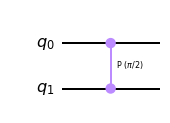

In [115]:
U = QuantumCircuit(2)
U.cp(2*np.pi*(1/4),0,1)
U.draw('mpl')

In [119]:
spe = alt_global_max_SPEA(U,resolution= 40,error = 3,max_iters=20)

In [136]:
result = spe.get_eigen_pair(progress = False,backend=simulator)

In [137]:
result 

{'cost': 1.0, 'theta': 0.0, 'state': array([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])}

## Testing for the 3-qubit Unitary 

In [113]:
U = QuantumCircuit(3)
U.cp(2*np.pi*(1/4),1,2)
U.draw('mpl')

errors = []
eigvals = np.array([0.0,0.25,1.0])

for resolution in range(10,80,10):
    spe = alt_global_max_SPEA(U,resolution= resolution,error = 4,max_iters=15)    
    res = spe.get_eigen_pair(backend = simulator)
    theta = res['theta']
    min_error = 1e5 
    # get percentage error 
    for e in eigvals:
        error = abs(e-theta) 
        if error < min_error:
            min_error = error 
            if e != 0:
                perc_error = (error/e)*100 
            else:
                perc_error = error*100
    errors.append(perc_error)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...


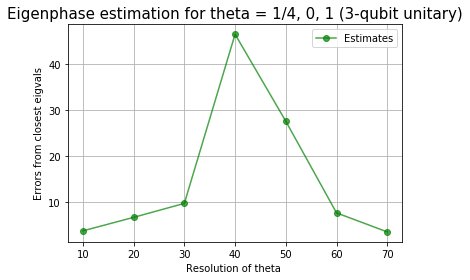

In [114]:
plt.title("Eigenphase estimation for theta = 1/4, 0, 1 (3-qubit unitary)",fontsize = 15)
plt.grid()
plt.plot(list(range(10,80,10)),errors,marker = 'o',color='g',label = 'Estimates',alpha=0.7)
# plt.plot([10,80],[0.25,0.25],color='black',label = "True")
# plt.plot([10,80],[0,0],color='black',label = "True")
# plt.plot([10,80],[1,1],color='black',label = "True")
plt.legend()
plt.xlabel("Resolution of theta ")
plt.ylabel("Errors from closest eigvals")
plt.savefig("Alternate_SPE_PLOT_1.jpg",dpi = 200)

## Testing for 2 qubit unitary on simulator
- 2 qubit controlled phase unitary is used for testing on actual backends

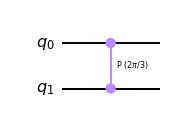

In [147]:
U = QuantumCircuit(2)
U.cp(2*np.pi*(1/3),0,1)
U.draw('mpl')

In [148]:
eigvals = np.array([0.0,1/3,1.0])

In [151]:
errors = []
for resolution in range(10,80,10):
    spe = alt_global_max_SPEA(U,resolution= resolution,error = 4,max_iters=15)    
    #run 5 experiments of this 
    p_errors = []
    for exp in range(5):
        res = spe.get_eigen_pair(progress = True,backend = simulator)
        theta = result['theta']
        min_error = 1e5 
        # get percentage error 
        for e in eigvals:
            error = abs(e-theta) 
            if error < min_error:
                min_error = error 
                if e != 0:
                    perc_error = (error/e)*100 
                else:
                    perc_error = error*100
        p_errors.append(perc_error)
    errors.append(np.average(p_errors))

Right : 0.4722222222222222
Left : 0
ITERATION NUMBER 1 ...
100.000000 %completedBest Phi is : [-0.38678527-0.13891842j  0.54278496+0.0640301j  -0.13730718-0.434809j
  0.40530457-0.40024936j]
Theta estimate : 0.15740740740740738
Current cost : 0.76171875

COST : 0.76171875
THETA : 0.15740740740740738
Right : 0.2824074074074074
Left : 0.032407407407407385
ITERATION NUMBER 2 ...
100.000000 %completedBest Phi is : [-0.37291633-0.03881456j  0.58979604+0.10412055j -0.06754658-0.53774713j
  0.28943671-0.35102457j]
Theta estimate : 0.1435185185185185
Current cost : 0.837890625

COST : 0.837890625
THETA : 0.1435185185185185
Right : 0.2060185185185185
Left : 0.08101851851851849
ITERATION NUMBER 3 ...
100.000000 %completedBest Phi is : [-0.35559876+0.02490888j  0.60567861+0.12687716j -0.02220348-0.58993267j
  0.21003093-0.31202267j]
Theta estimate : 0.09490740740740738
Current cost : 0.83984375

COST : 0.83984375
THETA : 0.09490740740740738
Right : 0.12615740740740738
Left : 0.06365740740740738
I

100.000000 %completed
No change, updating a...

COST : 0.94140625
THETA : 0.9494598765432098
Right : 0.9650848765432098
Left : 0.9338348765432098
ITERATION NUMBER 6 ...
100.000000 %completed
No change, updating a...

COST : 0.94140625
THETA : 0.9494598765432098
Right : 0.9650848765432098
Left : 0.9338348765432098
ITERATION NUMBER 7 ...
100.000000 %completed
No change, updating a...

COST : 0.94140625
THETA : 0.9494598765432098
Right : 0.9650848765432098
Left : 0.9338348765432098
ITERATION NUMBER 8 ...
100.000000 %completedBest Phi is : [-0.31850212+0.73898868j -0.24369373-0.42836223j  0.25543135+0.00704126j
 -0.19012633-0.09015829j]
Theta estimate : 0.951195987654321
Current cost : 0.9453125

COST : 0.9453125
THETA : 0.951195987654321
Right : 0.959008487654321
Left : 0.943383487654321
ITERATION NUMBER 9 ...
100.000000 %completed
No change, updating a...

COST : 0.9453125
THETA : 0.951195987654321
Right : 0.959008487654321
Left : 0.943383487654321
ITERATION NUMBER 10 ...
100.000000 %com

100.000000 %completed
No change, updating a...

COST : 0.96875
THETA : 0.9498135288065843
Right : 0.9537197788065843
Left : 0.9459072788065843
ITERATION NUMBER 8 ...
100.000000 %completed
No change, updating a...

COST : 0.96875
THETA : 0.9498135288065843
Right : 0.9537197788065843
Left : 0.9459072788065843
ITERATION NUMBER 9 ...
100.000000 %completed
No change, updating a...

COST : 0.96875
THETA : 0.9498135288065843
Right : 0.9537197788065843
Left : 0.9459072788065843
ITERATION NUMBER 10 ...
100.000000 %completedBest Phi is : [0.40515743+0.37968001j 0.62562939-0.23505554j 0.41877421+0.20536356j
 0.1588619 -0.04737277j]
Theta estimate : 0.9537197788065843
Current cost : 0.970703125

COST : 0.970703125
THETA : 0.9537197788065843
Right : 0.9556729038065843
Left : 0.9517666538065843
ITERATION NUMBER 11 ...
100.000000 %completedBest Phi is : [0.40532576+0.38168053j 0.62564627-0.23298492j 0.41779185+0.20457585j
 0.15971748-0.04903866j]
Theta estimate : 0.9552388760288065
Current cost : 0.9

100.000000 %completedBest Phi is : [ 0.36374538+0.54427311j  0.40787826+0.48180543j  0.15700304-0.33093761j
 -0.19555166-0.02334146j]
Theta estimate : 0.947423093745444
Current cost : 0.9609375

COST : 0.9609375
THETA : 0.947423093745444
Right : 1
Left : 0.884923093745444
ITERATION NUMBER 3 ...
100.000000 %completedBest Phi is : [ 0.34320294+0.53404514j  0.42215395+0.4871748j   0.14442177-0.34593417j
 -0.1977322 -0.04275707j]
Theta estimate : 0.9636599243406665
Current cost : 0.96484375

COST : 0.96484375
THETA : 0.9636599243406665
Right : 0.9949099243406665
Left : 0.9324099243406665
ITERATION NUMBER 4 ...
100.000000 %completed
No change, updating a...

COST : 0.96484375
THETA : 0.9636599243406665
Right : 0.9949099243406665
Left : 0.9324099243406665
ITERATION NUMBER 5 ...
100.000000 %completed
No change, updating a...

COST : 0.96484375
THETA : 0.9636599243406665
Right : 0.9949099243406665
Left : 0.9324099243406665
ITERATION NUMBER 6 ...
100.000000 %completed
No change, updating a...



100.000000 %completed
No change, updating a...

COST : 0.99609375
THETA : 0.03215090046884232
Right : 0.06340090046884232
Left : 0.0009009004688423222
ITERATION NUMBER 11 ...
100.000000 %completed
No change, updating a...

COST : 0.99609375
THETA : 0.03215090046884232
Right : 0.06340090046884232
Left : 0.0009009004688423222
ITERATION NUMBER 12 ...
100.000000 %completed
No change, updating a...

COST : 0.99609375
THETA : 0.03215090046884232
Right : 0.06340090046884232
Left : 0.0009009004688423222
ITERATION NUMBER 13 ...
100.000000 %completed
No change, updating a...

COST : 0.99609375
THETA : 0.03215090046884232
Right : 0.06340090046884232
Left : 0.0009009004688423222
ITERATION NUMBER 14 ...
100.000000 %completed
No change, updating a...

COST : 0.99609375
THETA : 0.03215090046884232
Right : 0.06340090046884232
Left : 0.0009009004688423222
ITERATION NUMBER 15 ...
100.000000 %completed
No change, updating a...

COST : 0.99609375
THETA : 0.03215090046884232
Maximum iterations reached for 

100.000000 %completed
No change, updating a...

COST : 0.96484375
THETA : 0.05983934868178277
Right : 0.06765184868178277
Left : 0.05202684868178277
ITERATION NUMBER 15 ...
100.000000 %completed
No change, updating a...

COST : 0.96484375
THETA : 0.05983934868178277
Maximum iterations reached for the estimation.
Terminating algorithm...
Right : 1
Left : 0.6120689655172413
ITERATION NUMBER 1 ...
100.000000 %completedBest Phi is : [-0.06992967+0.29402054j -0.4971206 +0.58745967j  0.08427218+0.32670312j
 -0.25475879-0.37105961j]
Theta estimate : 0.866230677764566
Current cost : 0.677734375

COST : 0.677734375
THETA : 0.866230677764566
Right : 0.991230677764566
Left : 0.741230677764566
ITERATION NUMBER 2 ...
100.000000 %completedBest Phi is : [ 0.04375549+0.25789801j -0.46269838+0.50499016j  0.16088636+0.52448981j
 -0.19240829-0.35280913j]
Theta estimate : 0.8964030915576694
Current cost : 0.77734375

COST : 0.77734375
THETA : 0.8964030915576694
Right : 0.9589030915576694
Left : 0.83390309

100.000000 %completedBest Phi is : [-0.27073441+0.26589345j -0.25253803-0.38670252j  0.76052577+0.16247411j
  0.14706579+0.12752895j]
Theta estimate : 0.04274878902444715
Current cost : 0.978515625

COST : 0.978515625
THETA : 0.04274878902444715
Right : 0.05837378902444715
Left : 0.027123789024447148
ITERATION NUMBER 5 ...
100.000000 %completed
No change, updating a...

COST : 0.978515625
THETA : 0.04274878902444715
Right : 0.05837378902444715
Left : 0.027123789024447148
ITERATION NUMBER 6 ...
100.000000 %completed
No change, updating a...

COST : 0.978515625
THETA : 0.04274878902444715
Right : 0.05837378902444715
Left : 0.027123789024447148
ITERATION NUMBER 7 ...
100.000000 %completed
No change, updating a...

COST : 0.978515625
THETA : 0.04274878902444715
Right : 0.05837378902444715
Left : 0.027123789024447148
ITERATION NUMBER 8 ...
100.000000 %completed
No change, updating a...

COST : 0.978515625
THETA : 0.04274878902444715
Right : 0.05837378902444715
Left : 0.027123789024447148
IT

100.000000 %completed
No change, updating a...

COST : 0.9921875
THETA : 0.03387628266724762
Right : 0.04950128266724762
Left : 0.01825128266724762
ITERATION NUMBER 11 ...
100.000000 %completed
No change, updating a...

COST : 0.9921875
THETA : 0.03387628266724762
Right : 0.04950128266724762
Left : 0.01825128266724762
ITERATION NUMBER 12 ...
100.000000 %completed
No change, updating a...

COST : 0.9921875
THETA : 0.03387628266724762
Right : 0.04950128266724762
Left : 0.01825128266724762
ITERATION NUMBER 13 ...
100.000000 %completed
No change, updating a...

COST : 0.9921875
THETA : 0.03387628266724762
Right : 0.04950128266724762
Left : 0.01825128266724762
ITERATION NUMBER 14 ...
100.000000 %completedBest Phi is : [-0.37561287+0.87738766j -0.01145645-0.10117281j  0.10523083-0.22547594j
  0.06120665+0.11436563j]
Theta estimate : 0.024661539077504027
Current cost : 0.99609375

COST : 0.99609375
THETA : 0.024661539077504027
Right : 0.03247403907750403
Left : 0.016849039077504027
ITERATION 

100.000000 %completedBest Phi is : [-0.13639429+0.08182182j -0.4640199 +0.62180572j -0.12202121+0.52824733j
 -0.27168404+0.07069886j]
Theta estimate : 0.9192554240631163
Current cost : 0.87109375

COST : 0.87109375
THETA : 0.9192554240631163
Right : 0.9505054240631163
Left : 0.8880054240631163
ITERATION NUMBER 4 ...
100.000000 %completedBest Phi is : [-0.15085755+0.10307071j -0.49344545+0.63238768j -0.10165376+0.50641247j
 -0.22635116+0.07206884j]
Theta estimate : 0.945697731755424
Current cost : 0.923828125

COST : 0.923828125
THETA : 0.945697731755424
Right : 0.961322731755424
Left : 0.930072731755424
ITERATION NUMBER 5 ...
100.000000 %completedBest Phi is : [-0.15857989+0.11465042j -0.50878787+0.63700586j -0.09015817+0.49330308j
 -0.20076466+0.07268611j]
Theta estimate : 0.945297090729783
Current cost : 0.939453125

COST : 0.939453125
THETA : 0.945297090729783
Right : 0.953109590729783
Left : 0.937484590729783
ITERATION NUMBER 6 ...
100.000000 %completed
No change, updating a...

CO

100.000000 %completedBest Phi is : [-0.00664696-0.08520956j -0.2252618 +0.14615091j  0.06264614+0.18808011j
 -0.43346536-0.83270721j]
Theta estimate : 0.2986987843606831
Current cost : 0.9296875

COST : 0.9296875
THETA : 0.2986987843606831
Right : 0.3006519093606831
Left : 0.2967456593606831
ITERATION NUMBER 8 ...
100.000000 %completed
No change, updating a...

COST : 0.9296875
THETA : 0.2986987843606831
Right : 0.3006519093606831
Left : 0.2967456593606831
ITERATION NUMBER 9 ...
100.000000 %completedBest Phi is : [ 0.01427735-0.06498153j -0.22734887+0.12962401j  0.05759276+0.18684798j
 -0.44149749-0.83302733j]
Theta estimate : 0.3006519093606831
Current cost : 0.935546875

COST : 0.935546875
THETA : 0.3006519093606831
Right : 0.3016284718606831
Left : 0.2996753468606831
ITERATION NUMBER 10 ...
100.000000 %completed
No change, updating a...

COST : 0.935546875
THETA : 0.3006519093606831
Right : 0.3016284718606831
Left : 0.2996753468606831
ITERATION NUMBER 11 ...
100.000000 %completedBes

100.000000 %completed
No change, updating a...

COST : 0.986328125
THETA : 0.9650685646499333
Right : 0.9689748146499333
Left : 0.9611623146499333
ITERATION NUMBER 12 ...
100.000000 %completed
No change, updating a...

COST : 0.986328125
THETA : 0.9650685646499333
Right : 0.9689748146499333
Left : 0.9611623146499333
ITERATION NUMBER 13 ...
100.000000 %completed
No change, updating a...

COST : 0.986328125
THETA : 0.9650685646499333
Right : 0.9689748146499333
Left : 0.9611623146499333
ITERATION NUMBER 14 ...
100.000000 %completed
No change, updating a...

COST : 0.986328125
THETA : 0.9650685646499333
Right : 0.9689748146499333
Left : 0.9611623146499333
ITERATION NUMBER 15 ...
100.000000 %completedBest Phi is : [ 0.59450562-0.28849011j  0.02332684+0.53838948j -0.47652582+0.16200544j
  0.08051765-0.11455751j]
Theta estimate : 0.9684964983234027
Current cost : 0.9921875

COST : 0.9921875
THETA : 0.9684964983234027
Maximum iterations reached for the estimation.
Terminating algorithm...
Righ

100.000000 %completed
No change, updating a...

COST : 0.970703125
THETA : 0.943909796035622
Right : 1
Left : 0.818909796035622
ITERATION NUMBER 6 ...
100.000000 %completed
No change, updating a...

COST : 0.970703125
THETA : 0.943909796035622
Right : 1
Left : 0.818909796035622
ITERATION NUMBER 7 ...
100.000000 %completed
No change, updating a...

COST : 0.970703125
THETA : 0.943909796035622
Right : 1
Left : 0.818909796035622
ITERATION NUMBER 8 ...
100.000000 %completed
No change, updating a...

COST : 0.970703125
THETA : 0.943909796035622
Right : 1
Left : 0.818909796035622
ITERATION NUMBER 9 ...
100.000000 %completed
No change, updating a...

COST : 0.970703125
THETA : 0.943909796035622
Right : 1
Left : 0.818909796035622
ITERATION NUMBER 10 ...
100.000000 %completed
No change, updating a...

COST : 0.970703125
THETA : 0.943909796035622
Right : 1
Left : 0.818909796035622
ITERATION NUMBER 11 ...
100.000000 %completed
No change, updating a...

COST : 0.970703125
THETA : 0.943909796035622

100.000000 %completed
No change, updating a...

COST : 0.98046875
THETA : 0.04245530570765367
Right : 0.05026780570765367
Left : 0.03464280570765367
ITERATION NUMBER 12 ...
100.000000 %completed
No change, updating a...

COST : 0.98046875
THETA : 0.04245530570765367
Right : 0.05026780570765367
Left : 0.03464280570765367
ITERATION NUMBER 13 ...
100.000000 %completed
No change, updating a...

COST : 0.98046875
THETA : 0.04245530570765367
Right : 0.05026780570765367
Left : 0.03464280570765367
ITERATION NUMBER 14 ...
100.000000 %completed
No change, updating a...

COST : 0.98046875
THETA : 0.04245530570765367
Right : 0.05026780570765367
Left : 0.03464280570765367
ITERATION NUMBER 15 ...
100.000000 %completedBest Phi is : [-0.3369316 -0.7557106j   0.17826629-0.25706428j -0.06194197+0.4346076j
 -0.15336624+0.03571964j]
Theta estimate : 0.04470636502968757
Current cost : 0.986328125

COST : 0.986328125
THETA : 0.04470636502968757
Maximum iterations reached for the estimation.
Terminating algo

100.000000 %completed
No change, updating a...

COST : 0.994140625
THETA : 0.03450919176681612
Right : 0.03548575426681612
Left : 0.03353262926681612
ITERATION NUMBER 15 ...
100.000000 %completed
No change, updating a...

COST : 0.994140625
THETA : 0.03450919176681612
Maximum iterations reached for the estimation.
Terminating algorithm...
Right : 1
Left : 0.677536231884058
ITERATION NUMBER 1 ...
100.000000 %completed
No change, updating a...

COST : 0.88671875
THETA : 0.927536231884058
Right : 1
Left : 0.677536231884058
ITERATION NUMBER 2 ...
100.000000 %completedBest Phi is : [ 0.07506766+0.45221605j  0.10049929-0.01178419j -0.62461114+0.55336163j
 -0.28804091-0.01762918j]
Theta estimate : 0.9205524049569418
Current cost : 0.896484375

COST : 0.896484375
THETA : 0.9205524049569418
Right : 1
Left : 0.7955524049569418
ITERATION NUMBER 3 ...
100.000000 %completed
No change, updating a...

COST : 0.896484375
THETA : 0.9205524049569418
Right : 1
Left : 0.7955524049569418
ITERATION NUMBER 4

100.000000 %completed
No change, updating a...

COST : 0.9765625
THETA : 0.03964380555872093
Right : 0.07089380555872093
Left : 0.008393805558720928
ITERATION NUMBER 7 ...
100.000000 %completed
No change, updating a...

COST : 0.9765625
THETA : 0.03964380555872093
Right : 0.07089380555872093
Left : 0.008393805558720928
ITERATION NUMBER 8 ...
100.000000 %completed
No change, updating a...

COST : 0.9765625
THETA : 0.03964380555872093
Right : 0.07089380555872093
Left : 0.008393805558720928
ITERATION NUMBER 9 ...
100.000000 %completedBest Phi is : [-0.80491427-0.09350757j  0.23085399-0.49772176j  0.0839816 +0.05759174j
 -0.00360779-0.17879067j]
Theta estimate : 0.05096626932683687
Current cost : 0.98046875

COST : 0.98046875
THETA : 0.05096626932683687
Right : 0.06659126932683687
Left : 0.03534126932683687
ITERATION NUMBER 10 ...
100.000000 %completed
No change, updating a...

COST : 0.98046875
THETA : 0.05096626932683687
Right : 0.06659126932683687
Left : 0.03534126932683687
ITERATION NU

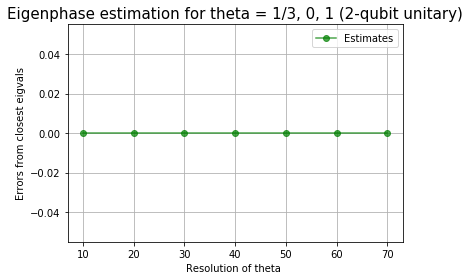

In [152]:
plt.title("Eigenphase estimation for theta = 1/3, 0, 1 (2-qubit unitary)",fontsize = 15)
plt.grid()
plt.plot(list(range(10,80,10)),errors,marker = 'o',color='g',label = 'Estimates',alpha=0.7)
# plt.plot([10,80],[0.25,0.25],color='black',label = "True")
# plt.plot([10,80],[0,0],color='black',label = "True")
# plt.plot([10,80],[1,1],color='black',label = "True")
plt.legend()
plt.xlabel("Resolution of theta ")
plt.ylabel("Errors from closest eigvals")
plt.savefig("Alternate_SPE_PLOT_1(simulator).jpg",dpi = 200)